In [1]:
import os
os.getcwd()
os.chdir('../')

In [2]:
os.getcwd()

'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia'

In [3]:
pip install -e ."[mujoco]

Obtaining file:///C:/Users/lschwitt/flygym_adhesion-Laetitia
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: flygym
    Found existing installation: flygym 0.0.1
    Uninstalling flygym-0.0.1:
      Successfully uninstalled flygym-0.0.1
  Running setup.py develop for flygym
Note: you may need to restart the kernel to use updated packages.


# Contact forces analysis with normal gravity

In [4]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

from scipy.signal import medfilt


## part 1: Static analysis split by leg

In [5]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 4000,## before 1942.73 at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#     data = pickle.load(f)
with open(data_path / 'behavior' / 'tripod_engineered.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>] actuators _adhesion


In [6]:
def interval_adhesion_state(off_duration, on_duration, off_increase, on_increase, num_steps):
    """
    off_duration, on_duration:  interval durations for which adhesion is on/ off,
    off_increase, on_increase:  by how many timesteps these intervals are increased size
    """
    adhesion_state = np.zeros(num_steps, dtype=bool)
    i = 0
    while i < num_steps:
        adhesion_state[i:i+off_duration] = False
        adhesion_state[i+off_duration:i+off_duration+on_duration] = True
        i += off_duration + on_duration
        off_duration += off_increase
        on_duration += on_increase
    return adhesion_state
off_duration = 40
on_duration = 40
off_increase = 40
on_increase = 40

adhesion_state = interval_adhesion_state(off_duration, on_duration, off_increase, on_increase, num_steps)


### auxiliary functions

In [7]:
# The simulation will be run twice, once with the adhesion: np.zeros(6) and once with np.ones(6) and np.zeros(6) alternating during varying times. 
# The adhesion is applied to the tarsus 5 of each leg.
# We want to plot the forces applied to the tarsus 5 of each leg. on the same plot but with 6 subplots, one for each leg. The first run is on the primary axis, the second run on the secondary axis. 
# The forces are plotted in the order of the legs: LFTarsus5, LHTarsus5, RMTarsus5, RFTarsus5, RHTarsus5, LMTarsus5
# The final video will be recorded. 


def run_simulation_static(num_steps, stabilization_steps = 1000, adhesion_feature = None):
    #adhesion_feature: Array denoting whether adhesion is on or off at each timestep.

    adhesion_states = np.zeros((num_steps,6))
    if adhesion_feature is not None:
        adhesion_states[adhesion_feature] = np.ones(6)
    
    # Run simulation
    nmf.physics.model.opt.gravity = (0,0,-9.81e5)
    obs, info = nmf.reset() 
    obs_list = [obs]
    for i in trange(num_steps + stabilization_steps):
        #calculate adhesion
        joint_pos = data_block[:, 0] #0 for static, i for dynamic
        
        # assign adhesion and joint positions to action
        if i <  stabilization_steps:
            adhesion = adhesion_states[0]
        else:
            adhesion = adhesion_states[i-stabilization_steps]
        action = {'joints': joint_pos, 'adhesion': adhesion}
        obs, info = nmf.step(action)
        nmf.render()
        obs_list.append(obs)	
    return obs_list, adhesion_states


In [8]:
"""
# Lets test the rules on the contact forces from the previous simulation

all_legs_contact_forces = []

for obs in obs_list_cruse_gapped:
    all_legs_contact_forces.append([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])

# Median filter the contact forces as the readout can be very noisy
all_legs_contact_forces = medfilt(all_legs_contact_forces, kernel_size=(21, 1))

plt.figure(figsize=(10, 4))
plt.plot(all_legs_contact_forces, label = legs)
plt.legend()
plt.show()
"""


'\n# Lets test the rules on the contact forces from the previous simulation\n\nall_legs_contact_forces = []\n\nfor obs in obs_list_cruse_gapped:\n    all_legs_contact_forces.append([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])\n\n# Median filter the contact forces as the readout can be very noisy\nall_legs_contact_forces = medfilt(all_legs_contact_forces, kernel_size=(21, 1))\n\nplt.figure(figsize=(10, 4))\nplt.plot(all_legs_contact_forces, label = legs)\nplt.legend()\nplt.show()\n'

In [9]:
n_stabilisation_steps = 1000

# Run the simulation with adhesion off
obs_list_simulation1, adhesion_states1 = run_simulation_static(num_steps,n_stabilisation_steps, adhesion_feature = None, )
#contact_forces on tarsus 5 of each leg
contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_simulation1]

# Run the simulation with adhesion on
obs_list_simulation2, adhesion_states2 = run_simulation_static(num_steps, n_stabilisation_steps, adhesion_feature = adhesion_state)
#contact_forces on tarsus 5 of each leg
contact_forces_simulation_adhesion = [obs['contact_forces'][4::5] for obs in obs_list_simulation2]



  0%|          | 0/11000 [00:00<?, ?it/s]

100%|██████████| 11000/11000 [00:17<00:00, 628.39it/s]


In [10]:
#for obs in obs_list_simulation1:
    #print(len(obs['contact_forces']))
contact_forces_simulation1sumTOT= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation1]
contact_forces_simulation2sumTOT= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation2]
    #print(contact_forces_simulation1sumTOT)
print(np.shape(contact_forces_simulation1sumTOT))
print(np.shape(contact_forces_simulation2sumTOT))

(11001, 6)
(11001, 6)


11001


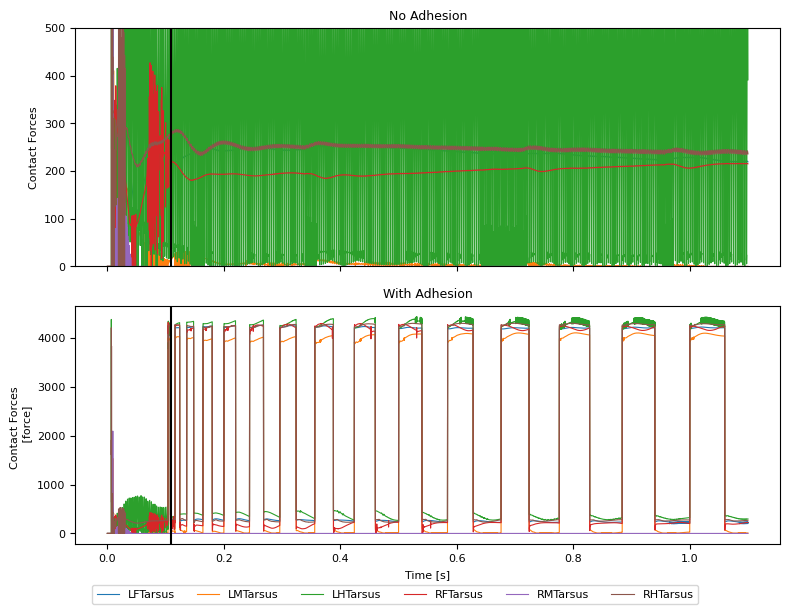

11001


<Figure size 640x480 with 0 Axes>

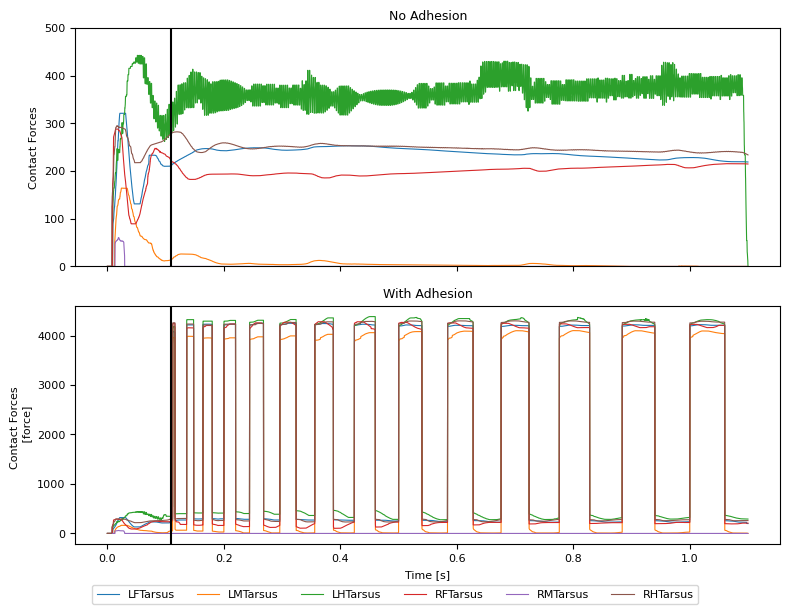

11001


<Figure size 640x480 with 0 Axes>

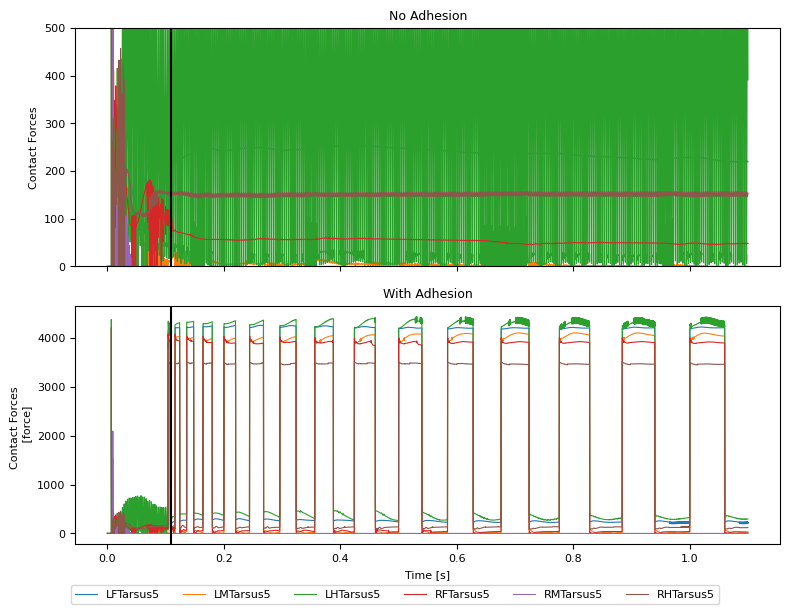

11001


<Figure size 640x480 with 0 Axes>

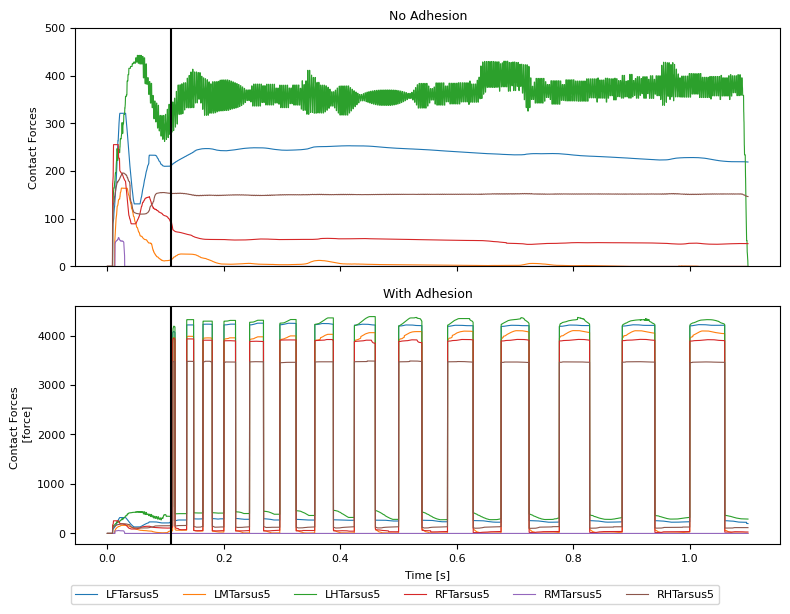

11001


<Figure size 640x480 with 0 Axes>

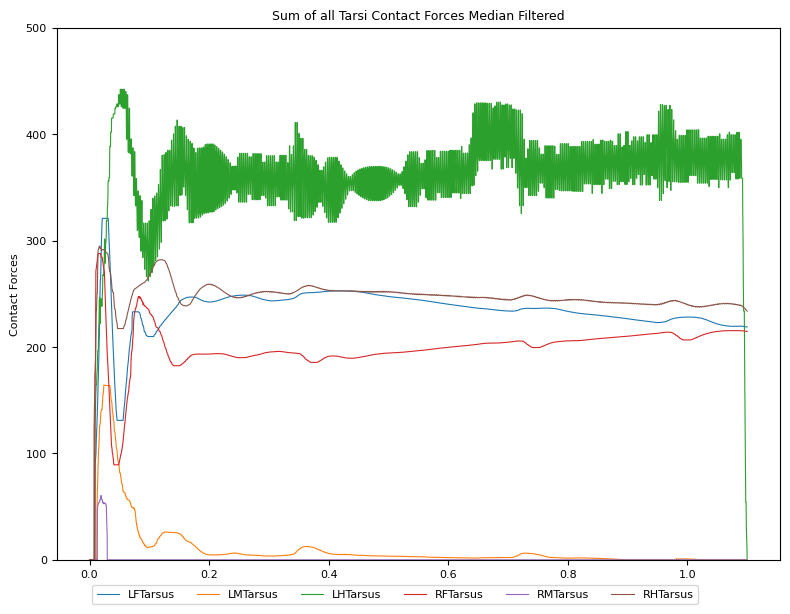

<Figure size 640x480 with 0 Axes>

In [14]:
def plot_contact_forces_comparison(obs_list_simulation_noADH, obs_list_simulation__adhesion, bool_sum_of_allTarsi = False, window_size_medfilt = 1):
    # tarsi
    if bool_sum_of_allTarsi:
        text_path = 'SumAllTarsi'
        tarsi = np.array(['LFTarsus', 'LMTarsus', 'LHTarsus', 'RFTarsus', 'RMTarsus', 'RHTarsus'])
        contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation_noADH]
        contact_forces_simulation_adhesion= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation__adhesion]



    else:
        text_path = 'onlyTarsi5'
        tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
        contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_simulation_noADH]
        contact_forces_simulation_adhesion = [obs['contact_forces'][4::5] for obs in obs_list_simulation__adhesion]


    assert window_size_medfilt % 2 == 1, "The window size for the median must be an odd integer"
    text_medfilt = ""
    if window_size_medfilt != 1:
        text_medfilt = "Median Filtered"
        

    # Extract the time and fly data for each simulation
    print(len(contact_forces_simulation_noADH))
    time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep

    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Plot data from the first simulation on the first subplot
    ax1.plot(time_simulation, medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1)),linewidth = 0.8)
    ax1.set_ylabel('Contact Forces',fontsize = 8)
    ax1.tick_params(labelsize=8)
    ax1.set_ylim(0, 500)
    ax1.set_title("No Adhesion", fontsize = 9)
    ax1.axvline(time_simulation[-1] * 0.1, color = 'black')



    # Plot data from the second simulation on the second subplot
    ax2.plot(time_simulation, medfilt(contact_forces_simulation_adhesion, (window_size_medfilt, 1)), linewidth = 0.8)
    ax2.set_xlabel('Time [s]',fontsize = 8)
    ax2.set_ylabel('Contact Forces \n [force]',fontsize = 8)
    ax2.tick_params(labelsize=8)
    #ax2.set_xlim(time_simulation[-1] * 0.1, time_simulation[-1])
    ax2.axvline(time_simulation[-1] * 0.1, color = 'black')

    ax2.set_title("With Adhesion", fontsize = 9)


    # Create a common legend outside the subplots
    fig.legend(labels = tarsi, loc='center', ncol = len(tarsi), bbox_to_anchor=(0.5, 0), fontsize=8)

    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0.2)

    # Title the entire figure
    if bool_sum_of_allTarsi:
        fig.suptitle(f'Sum of all Tarsi Contact Forces comparison without / with adhesion {text_medfilt}', fontsize = 10)
    else: 
        fig.suptitle(f'Contact Forces on Tarsi 5 comparison without / with adhesion {text_medfilt}',fontsize = 10)
    plt.tight_layout()

    fig = plt.gcf() 
    plt.show()
    plt.draw()

    #to save:
    save_path = Path('notebooks/ContactForcesFigures',f'contact_force_intervals_comparison_{text_path}_{text_medfilt.replace(" ","")}.png')
    fig.savefig(save_path)

def plot_contact_forces(obs_list_simulation, bool_sum_of_allTarsi = False, window_size_medfilt = 1):
    # tarsi
    if bool_sum_of_allTarsi:
        text_path = 'SumAllTarsi'
        tarsi = np.array(['LFTarsus', 'LMTarsus', 'LHTarsus', 'RFTarsus', 'RMTarsus', 'RHTarsus'])
        contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation]



    else:
        text_path = 'onlyTarsi5'
        tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
        contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_simulation]

    assert window_size_medfilt % 2 == 1, "The window size for the median must be an odd integer"
    text_medfilt = ""
    if window_size_medfilt != 1:
        text_medfilt = "Median Filtered"
        

    # Extract the time and fly data for each simulation
    print(len(contact_forces_simulation_noADH))
    time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep





    fig = plt.figure(figsize=(8, 6))

    # Plot data from the first simulation
    plt.plot(time_simulation, medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1)), linewidth=0.8)
    plt.ylabel('Contact Forces', fontsize=8)
    plt.tick_params(labelsize=8)
    plt.ylim(0, 500)
    
    if bool_sum_of_allTarsi:
        plt.title(f'Sum of all Tarsi Contact Forces {text_medfilt}', fontsize=9)
    else: 
        plt.title(f'Contact Forces on Tarsi 5 {text_medfilt}', fontsize=9)

    
    # Create a common legend outside the subplots
    fig.legend(labels=tarsi, loc='center', ncol=len(tarsi), bbox_to_anchor=(0.5, 0), fontsize=8)
    plt.tight_layout()

    fig = plt.gcf() 
    plt.show()
    plt.draw()

    #to save:
    save_path = Path('notebooks/ContactForcesFigures',f'contact_force_{text_path}_{text_medfilt.replace(" ","")}.png')
    fig.savefig(save_path)


#plot 
plot_contact_forces_comparison(obs_list_simulation1,obs_list_simulation2, bool_sum_of_allTarsi=True)
plot_contact_forces_comparison(obs_list_simulation1,obs_list_simulation2,bool_sum_of_allTarsi=True, window_size_medfilt= 201)
plot_contact_forces_comparison(obs_list_simulation1,obs_list_simulation2,bool_sum_of_allTarsi=False)
plot_contact_forces_comparison(obs_list_simulation1,obs_list_simulation2,bool_sum_of_allTarsi=False, window_size_medfilt= 201)


plot_contact_forces(obs_list_simulation1,bool_sum_of_allTarsi=True, window_size_medfilt=201)

11001


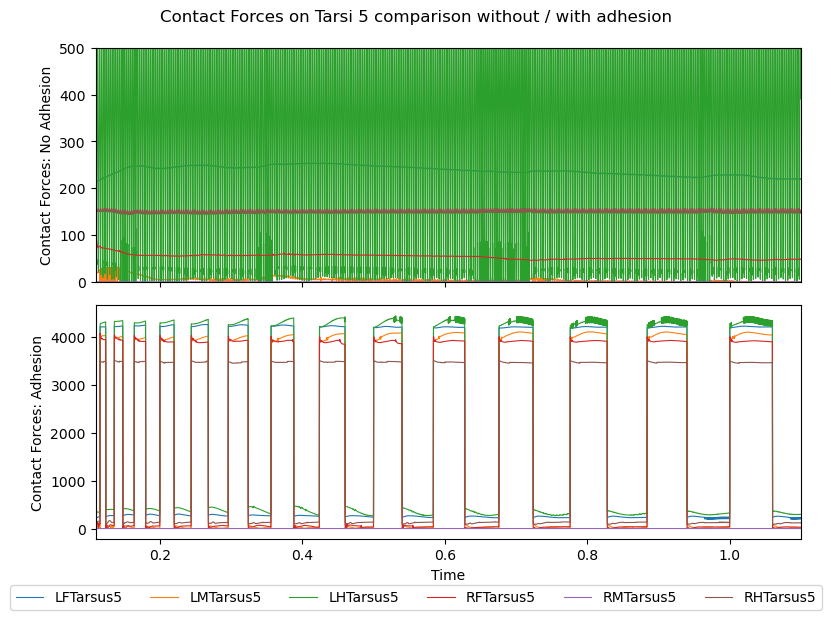

In [28]:
# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])

# Extract the time and fly data for each simulation
print(len(contact_forces_simulation_noADH))
time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot data from the first simulation on the first subplot
ax1.plot(time_simulation, contact_forces_simulation_noADH,linewidth = 0.8)
ax1.set_ylabel('Contact Forces: No Adhesion')
ax1.tick_params('y')
ax1.set_ylim(0, 500)

# Plot data from the second simulation on the second subplot
ax2.plot(time_simulation, contact_forces_simulation_adhesion, linewidth = 0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Contact Forces: Adhesion')
ax2.tick_params('y')
ax2.set_xlim(time_simulation[-1] * 0.1, time_simulation[-1])

# Create a common legend outside the subplots
fig.legend(labels = tarsi, loc='center', ncol = len(tarsi), bbox_to_anchor=(0.5, 0))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2)

# Title the entire figure
fig.suptitle('Contact Forces on Tarsi 5 comparison without / with adhesion')
plt.tight_layout()

# Show the figure with both subplots
plt.show()


11001


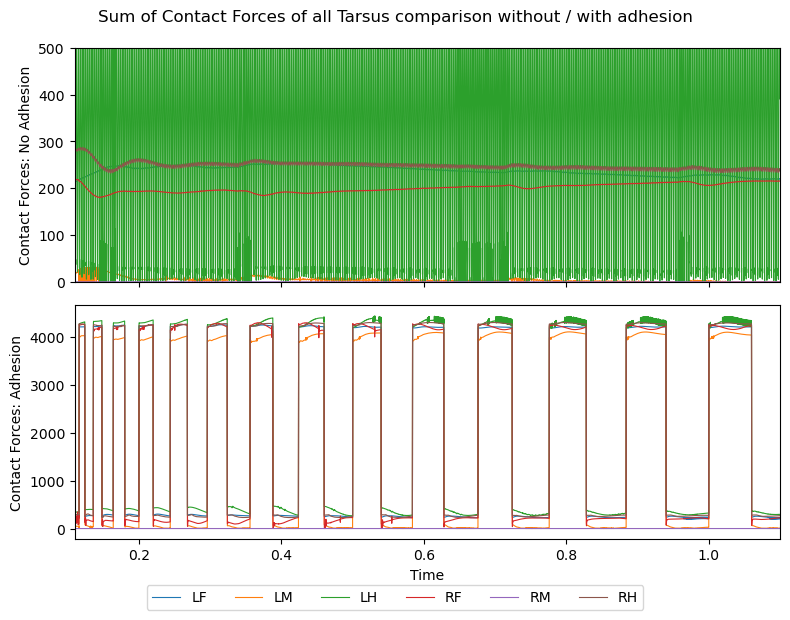

In [48]:
# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
legs = np.array(['LF', 'LM', 'LH', 'RF', 'RM', 'RH'])

# Extract the time and fly data for each simulation
print(len(contact_forces_simulation1sumTOT))
time_simulation = np.arange(len(contact_forces_simulation1sumTOT)) * nmf.timestep

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot data from the first simulation on the first subplot
ax1.plot(time_simulation, contact_forces_simulation1sumTOT, linewidth = 0.8)
ax1.set_ylabel('Contact Forces: No Adhesion')
ax1.tick_params('y')
ax1.set_ylim(0, 500)

# Plot data from the second simulation on the second subplot
ax2.plot(time_simulation, contact_forces_simulation2sumTOT, linewidth = 0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Contact Forces: Adhesion')
ax2.tick_params('y')
ax2.set_xlim(time_simulation[-1] * 0.1, time_simulation[-1])

# Create a common legend outside the subplots
fig.legend(labels = legs, loc='center', ncol = len(legs), bbox_to_anchor=(0.5, 0))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2)

# Title the entire figure
fig.suptitle('Sum of Contact Forces of all Tarsus comparison without / with adhesion')
plt.tight_layout()

# Show the figure with both subplots
plt.show()


## after medfilt

11001


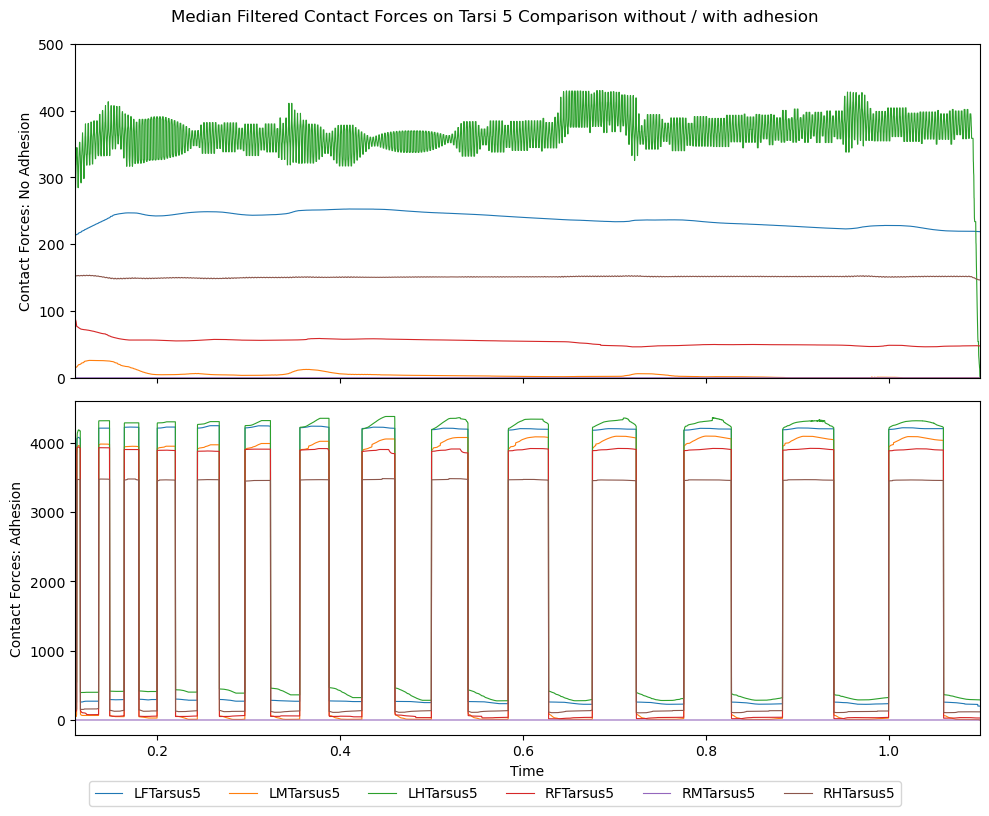

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Define window size for medfilt
window_size = 201

# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])

# Extract the time and fly data for each simulation
print(len(contact_forces_simulation_noADH))
time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot data from the first simulation on the first subplot
ax1.plot(time_simulation, medfilt(contact_forces_simulation_noADH, (window_size, 1)), linewidth = 0.8)
ax1.set_ylabel('Contact Forces: No Adhesion')
ax1.tick_params('y')
ax1.set_ylim(0, 500)

# Plot data from the second simulation on the second subplot
ax2.plot(time_simulation, medfilt(contact_forces_simulation_adhesion, (window_size, 1)), linewidth = 0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Contact Forces: Adhesion')
ax2.tick_params('y')
ax2.set_xlim(time_simulation[-1] * 0.1, time_simulation[-1])

# Create a common legend outside the subplots
fig.legend(labels=tarsi, loc='center', ncol=len(tarsi), bbox_to_anchor=(0.5, 0))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2)

# Title the entire figure
fig.suptitle('Median Filtered Contact Forces on Tarsi 5 Comparison without / with adhesion')

plt.tight_layout()

# Show the figure with both subplots
plt.show()


11001


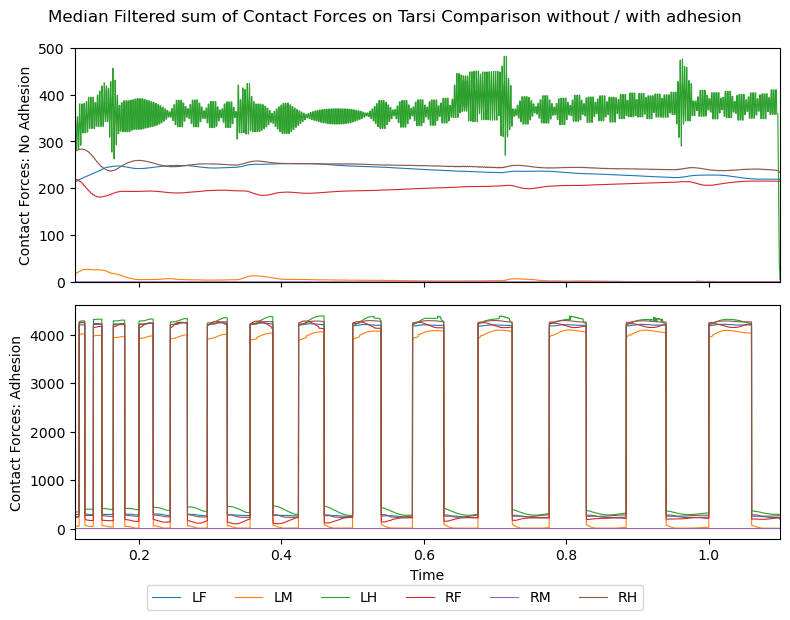

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Define window size for medfilt
window_size = 101

# tarsi
tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
legs = np.array(['LF', 'LM', 'LH', 'RF', 'RM', 'RH'])


# Extract the time and fly data for each simulation
print(len(contact_forces_simulation1sumTOT))
time_simulation = np.arange(len(contact_forces_simulation1sumTOT)) * nmf.timestep

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot data from the first simulation on the first subplot
ax1.plot(time_simulation, medfilt(contact_forces_simulation1sumTOT, (window_size, 1)),linewidth = 0.8)
ax1.set_ylabel('Contact Forces: No Adhesion')
ax1.tick_params('y')
ax1.set_ylim(0, 500)

# Plot data from the second simulation on the second subplot
ax2.plot(time_simulation, medfilt(contact_forces_simulation2sumTOT, (window_size, 1)), linewidth = 0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Contact Forces: Adhesion')
ax2.tick_params('y')
ax2.set_xlim(time_simulation[-1] * 0.1, time_simulation[-1])

# Create a common legend outside the subplots
fig.legend(labels=legs, loc='center', ncol=len(legs), bbox_to_anchor=(0.5, 0))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2)

# Title the entire figure
fig.suptitle('Median Filtered sum of Contact Forces on Tarsi Comparison without / with adhesion')

plt.tight_layout()

# Show the figure with both subplots
plt.show()


In [74]:
from scipy.signal import medfilt
import numpy as np

window_size_test = 3
nr_test_steps = 100
contact_forces_test = []
derivatives = [[] for _ in range(6)]  # Create an empty list for each leg
adhesion_array_test = []

for i in np.arange(nr_test_steps):
    random_numbers = np.random.rand(6)
    min_value = 200
    max_value = 400
    random_numbers_scaled = random_numbers * (max_value - min_value) + min_value
    contact_forces_test.append(random_numbers_scaled.astype(int).tolist())
    leg_contact_forces_median_test_old = 
    # Apply median filter to each leg separately and calculate derivatives
    if i >= window_size_test - 1:
        leg_contact_forces = contact_forces_test[i-window_size_test+1:i+1]
        leg_contact_forces_median_test = np.median(leg_contact_forces, axis = 0)
        leg_contact_forces_median_test_old = leg_contact_forces_median_test
        leg_contact_forces_median = medfilt(leg_contact_forces, (window_size_test, 1))
        #print(np.shape(leg_contact_forces))
        #print(np.shape(leg_contact_forces_median))
        derivative = np.gradient(leg_contact_forces_median, axis = 0)
        derivative = np.gradient(leg_contact_forces_median, axis = 0)

        derivatives.append(derivative)
    np.where(derivative >= 0, 1, 0)
print(np.shape(contact_forces_test))
print(leg_contact_forces)
print("median")
print(np.shape(leg_contact_forces_median_test))
print(leg_contact_forces_median_test)
print("leg_contact_forces_median")
print(leg_contact_forces_median)
print(np.shape(derivative))
print(derivative)
print(np.shape(derivatives))

(100, 6)
[[320, 326, 232, 272, 240, 209], [301, 396, 356, 331, 316, 324], [299, 392, 337, 216, 364, 313]]
median
(6,)
[301. 392. 337. 272. 316. 313.]
leg_contact_forces_median
[[301 326 232 272 240 209]
 [301 392 337 272 316 313]
 [299 392 337 216 316 313]]
(3, 6)
[[  0.   66.  105.    0.   76.  104. ]
 [ -1.   33.   52.5 -28.   38.   52. ]
 [ -2.    0.    0.  -56.    0.    0. ]]
(104,)


c:\Users\lschwitt\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


## part 2: Dynamic analysis split by leg 

-plot all contact forces (independent of tarsi, for each leg); this is to see whether the contribution of the other tarsi are relevant. Plot also the sum of all contact forces onto the same graph. 

In [ ]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 1942.73,#at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1942.73"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1942.73"/>] actuators _adhesion


In [ ]:
# Run simulation
nmf.physics.model.opt.gravity = (0,0,-9.81e5)
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
obs_deriv_touch_sensor_Tarsi5 = []
adhesion_obs = []
for i in trange(num_steps):
    deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    joint_pos = data_block[:, i] #put back i 
    #calculate adhesion
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [00:08<00:00, 1120.23it/s]


In [ ]:
for obs in obs_list: 
    print(obs['contact_forces'][4::5])

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


In [ ]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']
    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}